## AUTOMATIC TICKET ASSIGNMENT



### SUMMARY OF PROBLEM STATEMENT, DATA AND FINDINGS




**PROBLEM SYNOPSIS:**



*   **Business Domain:** Incident Management process in an IT function

*   **Purpose:** The main goal of Incident Management process is to provide a quick fix / workarounds or solutions that resolves interruption and restores service to its full capacity to ensure no business impact

*   **Source:** Incidents are created by various stakeholders (Business Users, IT Users and Monitoring Tools) within IT Service Management (ITSM) Tool and assigned to Service Desk teams (L1 / L2 teams)

*   **Workflow:** 

> Incidents from ITSM Tool are assigned to Service Desk teams (L1 / L2 teams)

> This team will review incidents for right ticket categorization, resolve or re-assign to other Functional teams from Applications and Infrastructure (L3 teams) as needed


*  **Workflow Shortcomings:**

> Assignment of incidents to appropriate IT groups is manual process 

> Manual assignment of incidents is inefficient and not cost effective 

>  Human errors during ticket assessment based on description leading to Incidents being assigned to incorrect functional group

> Increases response and resolution times which result in user satisfaction deterioration / poor customer service

##### **PROJECT OBJECTIVE:** Build an automated classifier that can classify tickets to appropriate resolver groups by analyzing text and augment/replace manual ticket categorization process

---




## APPROACH UNDERTAKEN

1.   Explore given Data files to understand structure of data 
and state hypothesis
2. Analyze data distribution patterns, data inconsistencies and text features  influencing incident distribution across groups
3.  Evaluate Hypothesis based on above findings and determine next steps 
4. Text Preprocessing to clean and prepare data for feature extraction
5. Decide which algorithms will be suitable and why?



#### Importing relevant libraries for loading and visualizing data

In [214]:
# Loading data
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf

# Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import random
random.seed(0) #Setting random seed for repeatable results

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Mount Google Drive and load Excel dataset into Pandas dataframe

In [215]:
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_excel('/content/drive/MyDrive/AIML Projects/NLP_AutoTicketAssignment/New folder/input_data.xlsx')
#df=pd.read_excel("/content/drive/MyDrive/Capstone_Project/input_data.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. Explore given data files to understand structure of data and state hypothesis


##### 1.a Understand structure of data

In [216]:
df.info()  # Display basic information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [217]:
df.isnull().sum() # To check if there are any null values in any of the columns

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [218]:
df #Dataframe head and tail contents

Short description  ... Assignment group
0                                           login issue  ...            GRP_0
1                                               outlook  ...            GRP_0
2                                    cant log in to vpn  ...            GRP_0
3                         unable to access hr_tool page  ...            GRP_0
4                                          skype error   ...            GRP_0
...                                                 ...  ...              ...
8495                  emails not coming in from zz mail  ...           GRP_29
8496                           telephony_software issue  ...            GRP_0
8497  vip2: windows password reset for tifpdchb pedx...  ...            GRP_0
8498                     machine nÃ£o estÃ¡ funcionando  ...           GRP_62
8499  an mehreren pc`s lassen sich verschiedene prgr...  ...           GRP_49

[8500 rows x 4 columns]

In [219]:
df.describe(include='all')

Short description Description             Caller Assignment group
count               8492        8499               8500             8500
unique              7481        7817               2950               74
top       password reset         the  bpctwhsn kzqsbmtp            GRP_0
freq                  38          56                810             3976

OBSERVATIONS:


1.   8500 rows and 4 columns with Data type as object


> Short Description and Description fields have mix of human input (emails, messages, etc) and system tool output (alerts, notifications, etc)

> Implication: Since incident description involves human input, grammatical errors, abbreviations, short forms and high degree of variance in text for description fields is expected and also seen.

> 8 null values in Short description and 1 null value in Description fields - These will need to be replaced with NAN

2. Caller field is not relavant for classification and can be dropped. 

3. Data transformation steps needed fr Description fields:
> Remove caller names to avoid verbose
> Visual inspection shows non-english language, symbols, spaces, junk characters and presence of usernames, Email ID, greetings,system acronyms, application names is expected in the description fields - These will need to be handled during pre-processing
> Duplicate fields will need to be removed thereafter

4. 74 Assigment Groups need to be analysed further to determine if this column can be used for classification 



##### 1.b Stating HYPOTHESIS

*   Given dataset lacks important information provided by ITSM tools such as Incident Severity and SLA Priority which are primarily used for assigning tickets to different functional groups

*   Absence of above information prompts us to assume that given Group Sructure of 74 groups is accurate and below hypothesis will be need to be proved to permit use of 'Assignment Group' as Target column for classification purposes:
 > Each group has distinct type of incidents. There is minimal/no overlap of incidents across groups 

 > Incident distribution across groups (aka classes) should not have significant imbalance 


#### 2. Analyze data distribution patterns, data inconsistencies and text features influencing incident distribution across groups

##### 2.a Analyzing group structure to determine data distribution

In [220]:
df['Assignment group'].unique() # Display unique group names 

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [221]:
df_grp = df['Assignment group'].value_counts().reset_index() # Get counts based on assignment group
df_grp['percentage'] = (df_grp['Assignment group']/df_grp['Assignment group'].sum())*100  # Calculate percentage based on the counts
df_grp

index  Assignment group  percentage
0    GRP_0              3976   46.776471
1    GRP_8               661    7.776471
2   GRP_24               289    3.400000
3   GRP_12               257    3.023529
4    GRP_9               252    2.964706
..     ...               ...         ...
69  GRP_67                 1    0.011765
70  GRP_70                 1    0.011765
71  GRP_73                 1    0.011765
72  GRP_61                 1    0.011765
73  GRP_64                 1    0.011765

[74 rows x 3 columns]

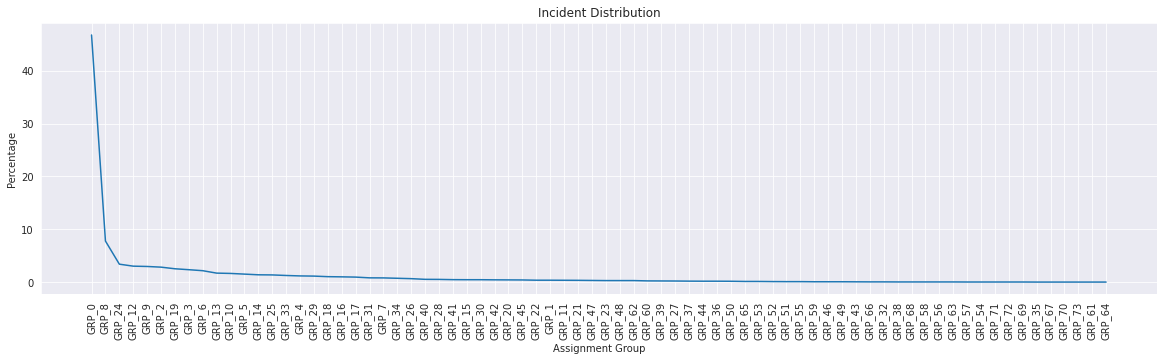

In [222]:
# View the distribution of incidents in every assignment group
plt.subplots(figsize = (20,5))
plt.plot(df_grp["index"], df_grp["percentage"]) 
plt.xlabel('Assignment Group') 
plt.ylabel('Percentage') 
plt.xticks(rotation=90)
plt.title('Incident Distribution')
plt.show()

In [223]:
df_tickets = pd.DataFrame(columns=['Description','Ticket Count'])
oneticket = {'Description':'1 ticket','Ticket Count':len(df_grp[df_grp['Assignment group'] < 2])}
_10ticket = {'Description':'< 10 tickets','Ticket Count':len(df_grp[(df_grp['Assignment group'] > 1)& (df_grp['Assignment group'] < 11) ])}
_50ticket = {'Description':'< 50 tickets','Ticket Count':len(df_grp[(df_grp['Assignment group'] > 10)& (df_grp['Assignment group'] < 51)])}
_100ticket = {'Description':'< 100 tickets','Ticket Count':len(df_grp[(df_grp['Assignment group'] > 50)& (df_grp['Assignment group'] < 101)])}
_100plusticket = {'Description':' > 100 tickets','Ticket Count':len(df_grp[(df_grp['Assignment group'] > 100)])}
#append row to the dataframe
df_tickets = df_tickets.append([oneticket,_10ticket,_50ticket,_100ticket,_100plusticket], ignore_index=True)
df_tickets
# This is to display and get understanding on how many tickets per assignment group we have in our dataframe

Description Ticket Count
0        1 ticket            6
1    < 10 tickets           19
2    < 50 tickets           25
3   < 100 tickets            9
4   > 100 tickets           15

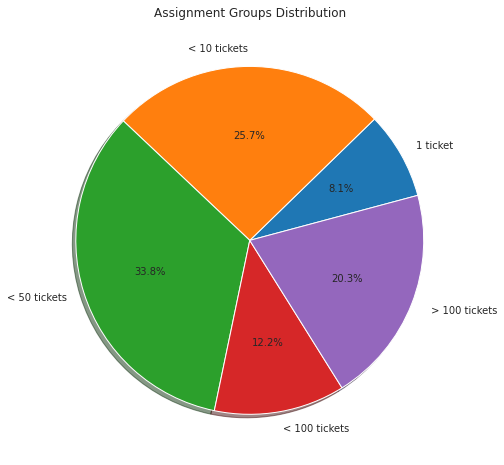

In [224]:
plt.figure(figsize=(10, 8))
plt.pie(df_tickets['Ticket Count'],labels=df_tickets['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution');

**OBSERVATIONS:**

1. Incident distribution across Groups is highly imbalanced
> GRP_0 @ ~47% , GRP_8 @ 8%, Majority groups averaging below 3% with some of them under 1% 

2. Distribution of the tickets across groups
 > 25 Groups range between 1 - 10 tickets

 > 25 Groups range between in 10 - 50 tickets

 > 9 Groups  range between 50 - 100 tickets

 > 15 Group has 100+ tickets


##### 2.b Resolve Text (data) inconsistencies in description fields influencing Incident distribution pattern across groups

2.b.1 Removing presence of null values

In [225]:
df[df.isnull().any(axis=1)]

Short description  ... Assignment group
2604                       NaN  ...           GRP_34
3383                       NaN  ...            GRP_0
3906                       NaN  ...            GRP_0
3910                       NaN  ...            GRP_0
3915                       NaN  ...            GRP_0
3921                       NaN  ...            GRP_0
3924                       NaN  ...            GRP_0
4341                       NaN  ...            GRP_0
4395  i am locked out of skype  ...            GRP_0

[9 rows x 4 columns]

In [226]:
#Replace NaN values with empty strings
df.replace(np.NaN," ", inplace=True)

df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

 2.b.2 Removing presence of caller fields in Short Description and Description fields

*Renaming columns*

In [227]:
#rename the columns
df.rename(columns = {"Assignment group" :"Group", "Short description": "Short_description"}, inplace=True)

Identify

In [228]:
#Find the maximum number of words in the caller name
print("Maximum number of words in the caller name : {}".format(max(df['Caller'].apply(lambda x: len(x.split())))))
# Add a column to indicate if the caller name is present in the Short_description column
df['Caller_in_SD'] = df.apply(lambda x: True if x.Caller.split()[0] in x.Short_description else True if x.Caller.split()[1] in x.Short_description else False, axis=1)
print("Number of rows in short description having caller name:{}".format(len(df[df['Caller_in_SD'] == True])))
# Add a column to indicate if the caller name is present in the Description column
df['Caller_in_Desc'] = df.apply(lambda x: True if x.Caller.split()[0] in x.Description else True if x.Caller.split()[1] in x.Description else False, axis=1)
print("Number of rows in description having caller name:{}".format(len(df[df['Caller_in_Desc'] == True])))

Maximum number of words in the caller name : 2
Number of rows in short description having caller name:381
Number of rows in description having caller name:1839


Replace

In [229]:
# replace first and second name with null string in Short Description column
df['SD_no_Caller'] = df.apply(lambda x : x['Short_description'].replace(str(x['Caller']).split()[0], ''), axis=1)
df['SD_no_Caller'] = df.apply(lambda x : x['SD_no_Caller'].replace(str(x['Caller']).split()[1], ''), axis=1)

# # replace first and second name with null string in Description column
df['Desc_no_Caller'] = df.apply(lambda x : x['Description'].replace(str(x['Caller']).split()[0], ''), axis=1)
df['Desc_no_Caller'] = df.apply(lambda x : x['Desc_no_Caller'].replace(str(x['Caller']).split()[1], ''), axis=1)

print("Count of Caller names in Short_description column : {}".format(df.apply(lambda x: True if x.Caller.split()[0] in x.SD_no_Caller else True if x.Caller.split()[1] in x.SD_no_Caller else False, axis=1).sum()))
print("Count of Caller names in Description column : {}".format(df.apply(lambda x: True if x.Caller.split()[0] in x.Desc_no_Caller else True if x.Caller.split()[1] in x.Desc_no_Caller else False, axis=1).sum()))

Count of Caller names in Short_description column : 0
Count of Caller names in Description column : 0


Verify

In [230]:
# Checking if Caller names have been removed from Short_description column
print("Original Short_description, without removing caller name: ", df['Short_description'].iloc[8447])
print("\nAfter removing caller name: ", df['SD_no_Caller'].iloc[8447])
print("*********************************************************")
# Checking if Caller names have been removed from Description column
print("Original Description, without removing caller name: ", df['Description'].iloc[8495])
print("\nAfter removing caller name : ", df['Desc_no_Caller'].iloc[8495])

Original Short_description, without removing caller name:  reset the password for obvyknzx gzvjtish on erp / production / erp

After removing caller name:  reset the password for   on erp / production / erp
*********************************************************
Original Description, without removing caller name:  

received from: avglmrts.vhqmtiua@gmail.com

good afternoon,
i am not receiving the emails that i sent from zz mail.
please advise



After removing caller name :  

received from: .@gmail.com

good afternoon,
i am not receiving the emails that i sent from zz mail.
please advise




*Drop columns*

In [231]:
df.drop(['Caller','Caller_in_SD','Caller_in_Desc'], axis = 1, inplace=True)
#Removing caller column and temporary columns (Caller_in_SD,Caller_in_Desc) which was created to evaluate the presence of caller names in short description and description
df.describe(include='all')

Short_description  ... Desc_no_Caller
count               8500  ...           8500
unique              7482  ...           7764
top       password reset  ...            the
freq                  38  ...             56

[4 rows x 5 columns]

**OBSERVATIONS**: 

As anticipated, after removing Caller names, number of duplicates in SD_no_Caller and Desc_no_caller have increased. It is desirable to analyze text in ticket distribution across groups and consider unique ones.

Other cleanup such as email ids and greetings, etc will be handleld downstream during Data Cleansing and removal of Stop words sections. This is being done to reduce noise and keep relevant words in the corpus and thereby reduce the Vocabulaory size that impacts text classification techniques


 2.b.3 Detecting presence of unrecognized unicode characters and Non-engish language in Description fields and converting them into English to refine the dataset

Detection

In [232]:
# https://pypi.org/project/ftfy/
# ftfy: fixes text for you : We intend to use this to address certain special characters in description*
# The goal of ftfy is to take in bad Unicode and output good Unicode, for use in Unicode-aware code. 

!pip install ftfy

     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=bb6b8f0722a0f66f3a5faac670f7320a6f2bc3ebe99c6d9936d3c3f1aad1c555
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy


In [233]:
from ftfy import fix_encoding, fix_text
# Sanitize the dataset using ftfy
df['SD_clean'] = df['SD_no_Caller'].apply(fix_text)
df['Desc_clean'] = df['Desc_no_Caller'].apply(fix_text)
df.iloc[7586]

Short_description    windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
Description          windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
Group                                                           GRP_31
SD_no_Caller         windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
Desc_no_Caller       windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
SD_clean                                windows 系统无法登录提示计算机与主域之前信任关系失败
Desc_clean                              windows 系统无法登录提示计算机与主域之前信任关系失败
Name: 7586, dtype: object

In [234]:
# https://pypi.org/project/polyglot
# Language detection using polyglot
# Polyglot is a natural language pipeline that supports massive multilingual applications
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install -q textstat

In [235]:
from polyglot.detect import Detector
import textstat
from tqdm import tqdm
import matplotlib.cm as cm
tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

def get_language(text):
    return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name

df["lang"] = df["Desc_clean"].progress_apply(get_language)

  0%|          | 0/8500 [00:00<?, ?it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the languag

In [236]:
df["lang"].unique()

array(['English', 'Latin', 'Kinyarwanda', 'Malay', 'Chinese', 'German',
       'Scots', 'Dutch', 'Welsh', 'Norwegian Nynorsk', 'Polish', 'Danish',
       'un', 'Portuguese', 'Japanese', 'Malagasy', 'Icelandic', 'Tagalog',
       'Nauru', 'Luxembourgish', 'Spanish', 'Turkish', 'Waray', 'Finnish',
       'Interlingua', 'Hungarian', 'French', 'Norwegian', 'Latvian'],
      dtype=object)

**OBSERVATIONS:**

1.  There is presence of multiple non english languages
2.  For converting them into english language we can use Google Translate API, however there is limit imposed from Google on number of requests for any unpaid service, so this cannot be used. 
3.  Due to the above limitation we will go for offline approach and convert the text from non english to english.

**CONVERSION TO ENGLISH LANGUAGE -**

*   We have used translate feature within GOOGLE SHEETS offline to 
translate into 'English' language

> New input file "input_data_Translate_v1.xlsx" has been generated.

In [237]:
# Load the Translated sheet
df_translated = pd.read_excel('/content/drive/MyDrive/AIML Projects/NLP_AutoTicketAssignment/New folder/input_data_Translate_v1.xlsx')
#df_translated = pd.read_excel('/content/drive/MyDrive/Capstone_Project/input_data_Translate_v1.xlsx')


In [238]:
# Verify that GOOGLE SHEETS has translated these instances correctly
df_translated.iloc[7586]

Short_description       windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
Description             windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
Group                                                              GRP_31
SD_no_Caller            windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
Desc_no_Caller          windows ç³»ç»Ÿæ— æ³•ç™»å½•æç¤ºè®¡ç®—æœºä¸Žä¸...
SD_clean                                   windows 系统无法登录提示计算机与主域之前信任关系失败
Desc_clean                                 windows 系统无法登录提示计算机与主域之前信任关系失败
SD_clean_translate      windows system can not login prompt before the...
Desc_clean_translate    windows system can not login prompt before the...
Name: 7586, dtype: object

2.b.4 Data Cleaning : 
> Removing presence of unnecessary verbose, greetings, email IDs, punctuations tags, dates and numbers. This will refine the text in Description fields.
> This cleanup shall help in refining the text content of the incidents, detect and remove additional duplicates. 

Data Cleansing

In [239]:
import re
from dateutil import parser

def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text=text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    
    # Below is in addition to STOP Words, to exclude continuous words/phrases/sentences for our problem statement These would have added to vocab size without contributing to the classification
    text=text.replace(('first name: ').lower(),'firstname')
    text=text.replace(('last name: ').lower(),'lastname')
    text=text.replace(('received from:').lower(),'')
    text=text.replace('email:','')
    text=text.replace('email address:','') 
    index1=text.find('from:')
    index2=text.find('\nsddubject:')
    text=text.replace(text[index1:index2],'')
    index3=text.find('[cid:image')
    index4=text.find(']')
    text=text.replace(text[index3:index4],'')
    text=text.replace('subject:','')
    text=text.replace('this communication is intended solely for the use of the addressee and may contain information that is worthy of protection, confidential or excluded from disclosure under applicable law. the distribution, distribution or reproduction of this communication by persons other than the intended recipients is strictly prohibited. if you have received this message by mistake, please notify the sender and delete this message.','')
    text=text.replace('how to','')
    text=text.replace('danke','')
    text=text.replace('hallo','')
    text=text.replace('mr','')
    text=text.replace('sir','')
    text=text.replace('ignore','')            
    text=text.replace('please ignore','')            
    text=text.replace('pls','')    
    text=text.replace('mailto','')            
    text=text.replace('company shared services gmbh','')                            
    text=text.replace('company infrastructure gmbh','')                            
    text=text.replace('good afternoon','')
    text=text.replace('this message was sent from an unmonitored email address', '')
    text=text.replace('please do not reply to this message', '')
    text=text.replace('monitoring_tool@company.com','MonitoringTool')
    text=text.replace('select the following link to view the disclaimer in an alternate language','')
    text=text.replace('description problem', '') 
    text=text.replace('steps taken far', '')
    text=text.replace('customer job title', '')
    text=text.replace('sales engineer contact', '')
    text=text.replace('description of problem:', '')
    text=text.replace('steps taken so far', '')
    text=text.replace('please do the needful', '')
    text=text.replace('please note that ', '')
    text=text.replace('please find below', '')
    text=text.replace('dear', '')
    text=text.replace('urgent', '')
    text=text.replace('date and time', '')
    text=text.replace('kindly refer mail', '')
    text=text.replace('name:', '')
    text=text.replace('language:', '')
    text=text.replace('customer number:', '')
    text=text.replace('telephone:', '')
    text=text.replace('summary:', '')
    text=text.replace('sincerely', '')
    text=text.replace('company inc', '')
    text=text.replace('importance:', '')
    text=text.replace('@gmail.com', '')
    text=text.replace('company.com', '')
    text=text.replace('microsoftonline.com', '')
    text=text.replace('company.onmicrosoft.com', '')
    text=text.replace('hello', '')
    text=text.replace('hi it team', '')
    text=text.replace('hi team', '')
    text=text.replace('team', '')
    text=text.replace('hi', '')
    text=text.replace('best', '')
    text=text.replace('kind', '')
    text=text.replace('regards', '')
    text=text.replace('good morning', '')
    text=text.replace('please', '')
    text=text.replace('regards', '')
    text=text.replace('cant', '')
    text=text.replace('etc', '')
    text=text.replace('ad', '')
    text=text.replace('cr', '')
    text=text.replace('ba', '')
    text=text.replace('pdf', '')
    text=text.replace('hxgaycze', '')
    text=text.replace('hlanwgqj', '')
    text=text.replace('thanks', '')
    text=text.replace('fgxprnub', '')
    text=text.replace('ndigung', '')
    text=text.replace('greeting', '')
    text=text.replace('friendly', '')
    text=text.replace('hlanwgqj', '')
    text=text.replace('tgryhu', '')
    text=text.replace('hgygrtui', '')
    text=text.replace('kw', '')
    text=text.replace('hxgayczeing', '')
    text=text.replace('uacyltoe', '')
    text=text.replace('mikhghytr', '')
    text=text.replace('wafglhdrhjop', '')
    text=text.replace('etcs', '')
    text=text.replace('sr', '')
    text=text.replace('sorry', '')
    text=text.replace('manager', '')
        
    
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    # Remove Numbers
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    # initializing punctuations string  
    punc = '''!()-[]{};:'",<>./?@#$%^&*~'''
    # Removing punctuations in string 
    for ele in text:
      if ele in punc:
        text = text.replace(ele, "")      

    return text

**IMPLICATION:**  - Replacing text is in addition to STOP Words, to exclude continuous words/phrases/sentences for our problem statement These would have added to vocab size without contributing to the classification

In [240]:
#Fill 'Short_Description' field entries that have null with blank space
df_translated['SD_clean_translate'].fillna(value=' ', inplace=True)

#Fill 'Description' field entries that have null with blank space
df_translated['Desc_clean_translate'].fillna(value=' ', inplace=True)

In [241]:
df_translated['SD_clean'] = df_translated['SD_clean_translate'].apply(lambda x: clean_text(x))

df_translated['Desc_clean'] = df_translated['Desc_clean_translate'].apply(lambda x: clean_text(x))

In [242]:
print(df_translated[['SD_clean_translate','SD_clean']].iloc[7387])

print(df_translated[['Desc_clean_translate','Desc_clean']].iloc[7387])

SD_clean_translate    unable to connect to companysecure at usa, oh
SD_clean               unable to connect to companysecure at usa oh
Name: 7387, dtype: object
Desc_clean_translate    contact # \nno one at the site is able to conn...
Desc_clean              contact no one at the site is able to connect ...
Name: 7387, dtype: object


In [243]:
df_translated[['SD_clean_translate','SD_clean','Desc_clean_translate','Desc_clean']].describe(include='all')

SD_clean_translate  ...                                         Desc_clean
count                                                8500  ...                                               8500
unique                                               7262  ...                                               6399
top     reset passwords for   using password_managemen...  ...  MonitoringTool job job failed in job scheduler at
freq                                                   61  ...                                                464

[4 rows x 4 columns]

**OBSERVATIONS**: 

As anticipated, after data cleansing, number of duplicates in SD_clean and Desc_clean columns have increased. These will be removed downstream

**IMPLICATION**: Data Cleansing has cleaned unecessary words, pucntuation marks, tags, email IDs. This will help in reducing the vocabulaory size - Avoids curse of dimensionality as well as aids in text classification

Remove STOP words

In [244]:
## Removal of Stop Words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['working','tried','etc','yes','na','t','company','unable','mistaking','addressee','disclaimer',',opportunity','called','pl','already','month','morning','could','able','help'])

df_translated['SD_clean'] = df_translated['SD_clean'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
df_translated['Desc_clean'] = df_translated['Desc_clean'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**IMPLICATION**: Above STOP words is an addition to earlier removal of words/phrases/sentences. During EDA, it was observed that these words added to the STOP words were not contributing to the quality of the Vocabulary and could have adversely impacted classification and led to curse of dimensionality

**SPELL CHECKER**
 - We explored Spell checker (pyChecker) for corrrecting some of the misspeld words identified during visual inspection eg: 'Laoding' , etc

  - It was very time consuming using this package in the available time to submit the EDA and we will need to expolore other options like (symspell - faster and needs less memory) to correct spellings in the coming weeks. 

**IMPLICATION:** Spell check will retain the accurate words. Will additionally help in reducing the vocabulary size as Lemmatization of the words will be more acurate.

Check and remove duplicates in short description and description columns

In [245]:
# without removing the gibberish characters, checking the number of duplicate rows
print("Number of common rows for Short description and description fields : {}".format(len(df_translated[df_translated[['SD_clean', 'Desc_clean']].duplicated()])))

Number of common rows for Short description and description fields : 1916


In [246]:
# Dropping the duplicate rows as it does not add much value

df_translated.drop_duplicates(['SD_clean', 'Desc_clean'], inplace = True)
df_translated.shape

(6584, 9)

*Merging the 2 description columns into 1 column called 'Clean_Description' based on condition*
* To avoid verbose, for rows that have same values in SD and Desc, we can pick only SD values. 
* For rows that have distinct values in SD and Desc, we shall concatenate the 2 columns

In [247]:
print('Same values in both SD_clean and Desc_clean fields:', len(df_translated[(df_translated['SD_clean'] == df_translated['Desc_clean'])]))
print('Distinct values in both SD_clean and Desc_clean fields:', len(df_translated[(df_translated['SD_clean'] != df_translated['Desc_clean'])]))

Same values in both SD_clean and Desc_clean fields: 2089
Distinct values in both SD_clean and Desc_clean fields: 4495


In [248]:
# Merging Short Description and Description Columns into 'Clean_Decription' based on below condition:
   # To avoid verbose, for rows that have same values in SD and Desc, we can pick only SD values
   # For rows that have distinct values in SD and Desc, we shall concatenate the 2 columns

df_translated["Clean_Description"] = np.where((df_translated['SD_clean'] == df_translated['Desc_clean']), df_translated['SD_clean'], df_translated["SD_clean"] + " " + df_translated["Desc_clean"])

**IMPLICATION:**

Removal of Duplicates helps in reducing memory usage and we get distinct rows as input for classification. 

Duplicate rows also impact word embeddings when using BOW or TF-IDF algorithms and hence need to be dropped

**REMARK**: For final submission we will also explore removal of duplicate words within the description field and evaluate if there is lift in performance

In [249]:
df_translated[['SD_clean','Desc_clean','Clean_Description']].iloc[1]

SD_clean                                                       outlook
Desc_clean           meetings skype meetings appearing outlook cale...
Clean_Description    outlook meetings skype meetings appearing outl...
Name: 1, dtype: object

2.b.5 Checking for Stemming and Lemmatization of the description fields

**stemming** *is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form .*

In [250]:
#Stemming
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

df_translated['CD_Stem']= df_translated['Clean_Description'].apply(lambda x: " ".join([stemmer.stem(word) for word in str(x).split()]))

In [251]:
df_translated[['Clean_Description','CD_Stem']]

Clean_Description                                            CD_Stem
0     login issue verified user details employee nam...  login issu verifi user detail employe name che...
1     outlook meetings skype meetings appearing outl...  outlook meet skype meet appear outlook calenda...
2                                log vpn cannot log vpn                             log vpn cannot log vpn
3                                   access hr tool page                                access hr tool page
4                                           skype error                                        skype error
...                                                 ...                                                ...
8495  emails coming zz mail receiving emails sent zz...  email come zz mail receiv email sent zz mail vise
8496                           telephony software issue                             telephoni softwar issu
8497       vip windows password reset tifpdchb pedxruyf        vip window password reset tifpdchb pedxruyf
8498  macne access macne utilities finish drawers ju...  macn access macn util finish drawer justment s...
8499  various prgramdntyme opened multiple pcs vario...  various prgramdntym open multipl pcs various p...

[6584 rows x 2 columns]

**OBSERVATIONS:** 
Stemming is causing last character of multiple words to be ommitted which is not correct in the context of the domain also there are acronyms used which will get ommitted due to these. Its best not to use stemming for this exercise

**Lemmatisation** *(or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form*

**IMPLICATION:** This helps in getting root words which reduces the Vocab size and addresses 'curse of Dimensionality'

In [252]:
## Lemmatization

nltk.download('wordnet')

from textblob import Word
df_translated['CD_Lem']= df_translated['Clean_Description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

df_translated['CD_Len'] = df_translated['Clean_Description'].apply(lambda x: len(x.split(" ")))
df_translated['CD_Lem_Len'] = df_translated['CD_Lem'].apply(lambda x: len(x.split(" ")))

print('Post Lemmatization, number of records that have reduced their word length are: ',len(df_translated[(df_translated['CD_Len'] != df_translated['CD_Lem_Len'])]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Post Lemmatization, number of records that have reduced their word length are:  198


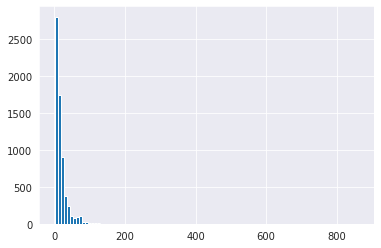

In [253]:
plt.hist(df_translated['CD_Lem_Len'], bins = 100)
plt.show()

#hist(stacked=True, bins=100, figsize=(12,50), layout=(14,2));

**OBSERVATION:**

Most rows are under 200 words.  There are > 2500 rows which have under 50 words

Post Lemmatization, number of records 198 words were removed reducing the overall Vocab size 

Running language detector for lemmatized column

In [254]:
df = df_translated.copy()
def get_language(text):
    return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name

df["lang"] = df["CD_Lem"].progress_apply(get_language)

  0%|          | 0/6584 [00:00<?, ?it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the languag

Plots from language detector - English v/s Non-English


In [255]:
lang_list = sorted(list(set(df["lang"])))
counts = [list(df["lang"]).count(cont) for cont in lang_list]
df2 = pd.DataFrame(np.transpose([lang_list, counts]))
df2.columns = ["Language", "Count"]
df2["Count"] = df2["Count"].apply(int)

df2_en = pd.DataFrame(np.transpose([["English", "Non-English"], [max(counts), sum(counts) - max(counts)]]))
df2_en.columns = ["Language", "Count"]

fig = px.bar(df2_en, x="Language", y="Count", title="Language of comments", color="Language", text="Count")
fig.update_layout(template="plotly_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[0].textfont.color = "black"
fig.data[0].textposition = "outside"
fig.data[1].textfont.color = "black"
fig.data[1].textposition = "outside"
fig

Visual display of other languages(Apart from English)

In [256]:
fig = px.bar(df2.query("Language != 'English' and Language != 'un'").query("Count >= 1"),
             y="Language", x="Count", title="Language of non-English comments", template="plotly_white", color="Language", text="Count", orientation="h")
fig.update_traces(marker=dict(line=dict(width=0.75,
                                        color='black')),  textposition="outside")
fig.update_layout(showlegend=False)
fig

Further evaluation of results of Polyglot as it was mentioned during its run Detector is not able to detect the language reliably

In [257]:
df[df['lang'] != 'English']

Short_description  ...            lang
4                                 skype error  ...           Latin
146                   erp_print_tool install.  ...     Kinyarwanda
148                  install acrobat standard  ...         Bislama
220                      adding members to dl  ...  Southern Sotho
281         unable to down load ethics module  ...         Spanish
...                                       ...  ...             ...
8396                           formatar micro  ...           Xhosa
8401                      company screensaver  ...           Wolof
8413  pobleme mit we_combi \jionmpsf wnkpzcmv  ...          Danish
8434             distributor_tool not laoding  ...           Waray
8482           robot HostName_776 is inactive  ...          Danish

[165 rows x 15 columns]

**OBSERVATIONS:**

1)Closer inspection of these 165 non english detected instances highlights that most of them are from english language, with exception of few words which google translate has not converted.

2)Based on the count and inpsection we decide to continue to retain these 165 rows as-is.

**RETAINING THESE NON ENGLISH rows:** We did not want to lose abbreviations ('erp', 'hr') and application/system names ('skype, hostname, etc) which were detected as Non english but we understand these rows are not.

##### 2.c Using Wordcloud to check for spread of incidents within Groups

In [258]:
from wordcloud import WordCloud,STOPWORDS
def generate_word_cloud(corpus):
    # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOPWORDS,
                    # mask=mask,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

Wordcloud of top 5 groups - GRP_0,GRP_8,GRP_24,GRP_12,GRP_9

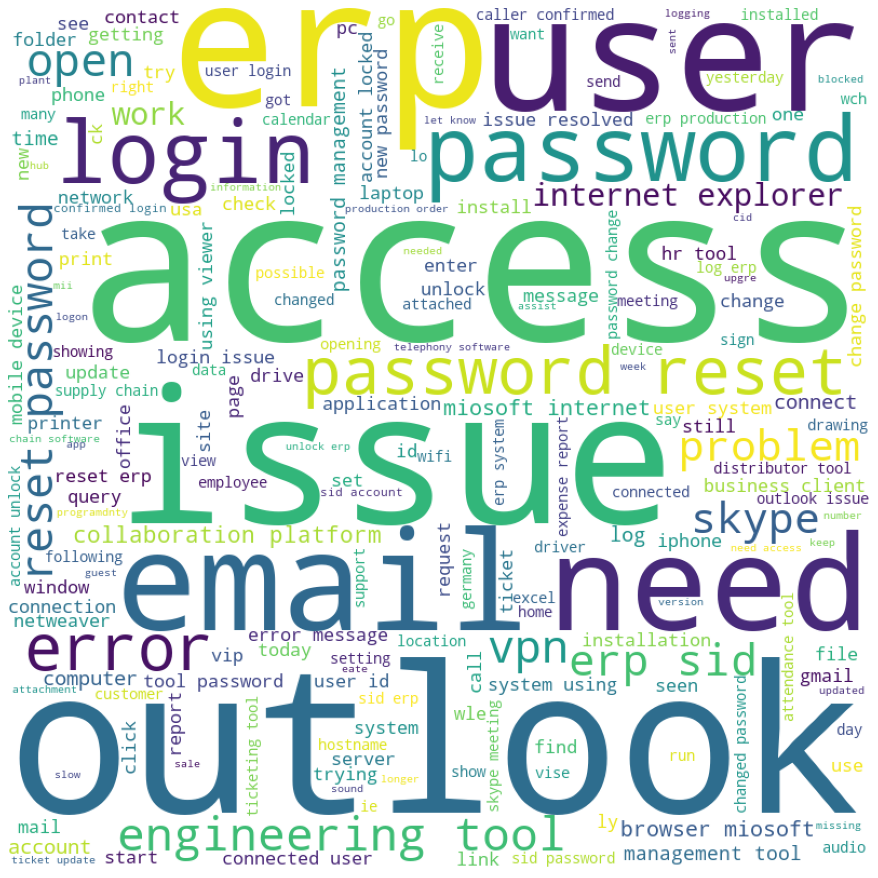

In [259]:
# Word Cloud for all tickets assigned to GRP_0 - First major grp
generate_word_cloud(' '.join(df[df['Group'] == 'GRP_0'].CD_Lem.str.strip()))

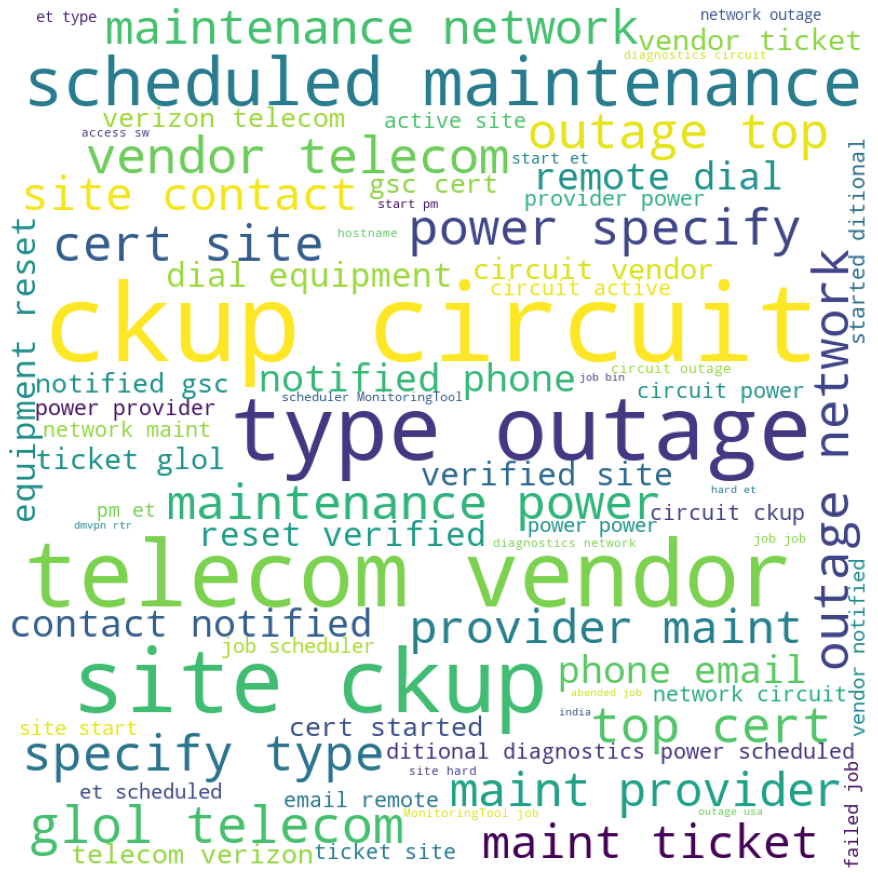

In [260]:
# Word Cloud for all tickets assigned to GRP_8 - Second major grp
generate_word_cloud(' '.join(df[df['Group'] == 'GRP_8'].CD_Lem.str.strip()))

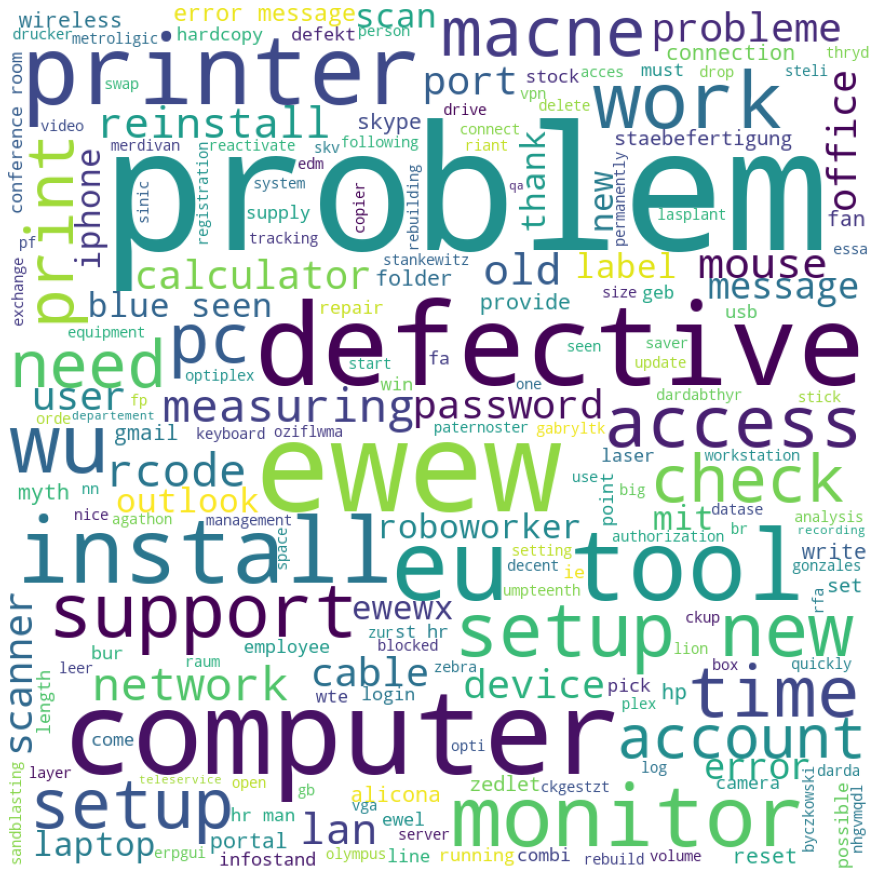

In [261]:
# Word Cloud for all tickets assigned to GRP_24 - Third major grp
generate_word_cloud(' '.join(df[df['Group'] == 'GRP_24'].CD_Lem.str.strip()))

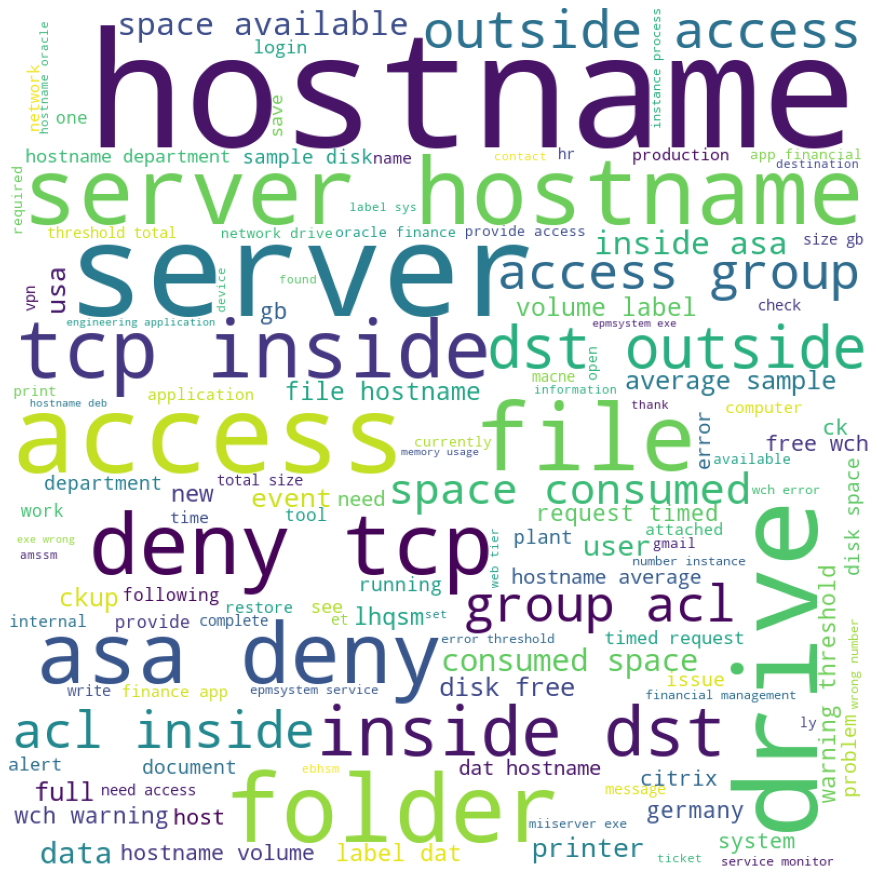

In [262]:
# Word Cloud for all tickets assigned to GRP_12 
generate_word_cloud(' '.join(df[df['Group'] == 'GRP_12'].CD_Lem.str.strip()))

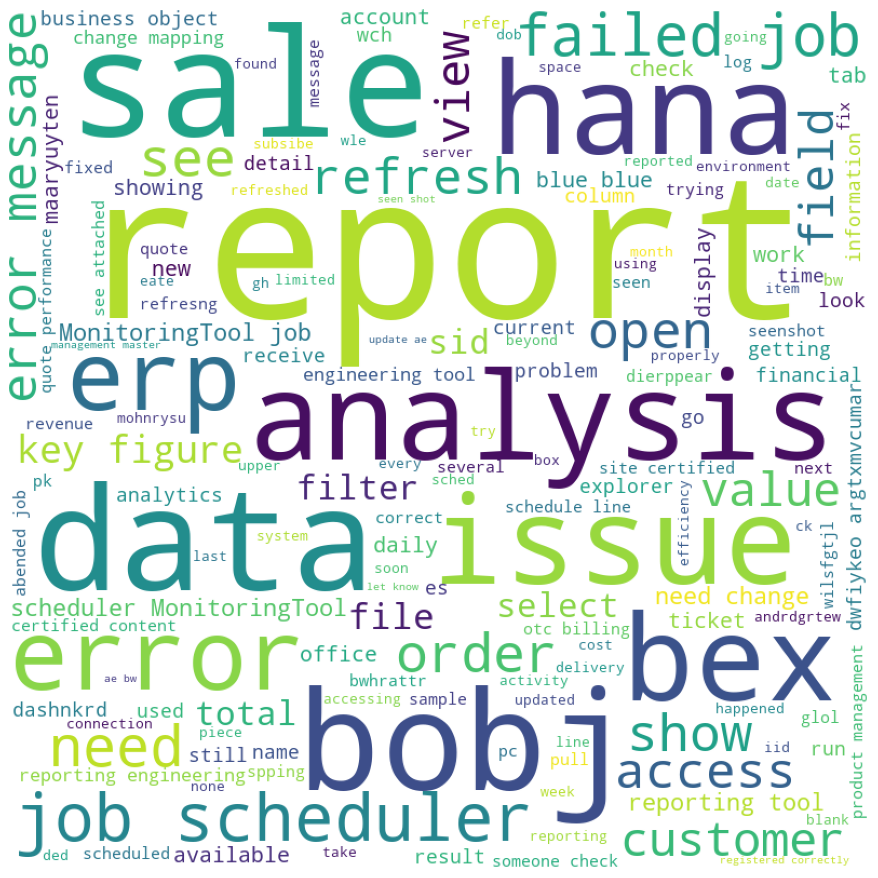

In [263]:
# Word Cloud for all tickets assigned to GRP_9
generate_word_cloud(' '.join(df[df['Group'] == 'GRP_9'].CD_Lem.str.strip()))

**OBSERVATION:** 

1.   GRP_0 - Most tickets related to User,access,outlook issues,password reset, access issues,login issue, connectivity issue related to various tools
2. GRP_8 - More tickets related to outage, job failures, monitoring tool,telecom 
3. GRP_24 - More tickets related to  IT infra setups like - workstation ,Printer ,skype,lan
4. GRP_12 - More tickets related to  network related issues citrix, acls
5. GRP_9 has more tickets related to  reports,analytics,job scheduler

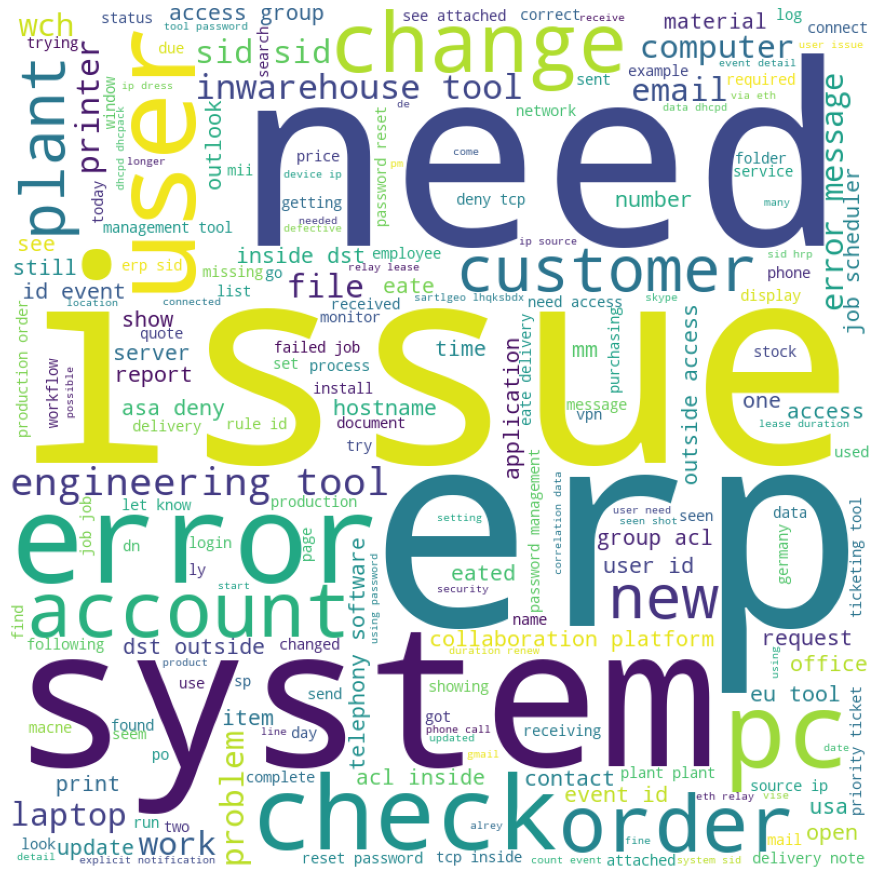

In [264]:
# Word Cloud for all tickets not assigned to GRPS - Other groups except 'GRP_0','GRP_8','GRP_24','GRP_12','GRP_9'
generate_word_cloud(' '.join(df[~df['Group'].isin(['GRP_0','GRP_8','GRP_24','GRP_12','GRP_9'])].CD_Lem.str.strip()))

Below is a distribution of Job Schedhler incidents which are also spread across different groups for similar incident type

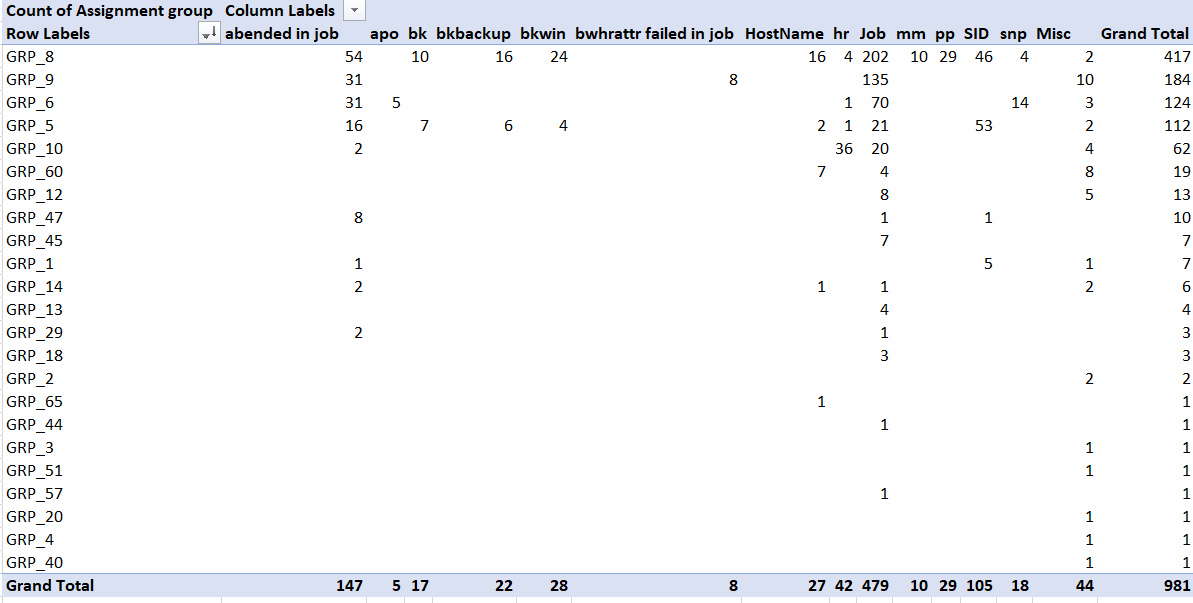

**Tokenization** is a process that splits an input sequence into tokens

In [265]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [266]:
# Tokenize the data
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
df['CD_Lem_token'] = df['CD_Lem'].apply(lambda x: tokenizer.tokenize(x))

df['CD_Lem_token'].head()

0    [login, issue, verified, user, detail, employe...
1    [outlook, meeting, skype, meeting, appearing, ...
2                         [log, vpn, cannot, log, vpn]
3                             [access, hr, tool, page]
4                                       [skype, error]
Name: CD_Lem_token, dtype: object

In [267]:
# Combine the text to form string 
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

df['CD_Lem_token_combined'] = df['CD_Lem_token'].apply(lambda x : combine_text(x))

In [268]:
#to process the simple_process gensim package as input needed as string 
Full_summary=df.CD_Lem_token_combined.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(Full_summary))

print(data_words[1])

['outlook', 'meeting', 'skype', 'meeting', 'appearing', 'outlook', 'calendar', 'somebody', 'vise', 'correct']


In [269]:
# Creating Bigrams and Trigrams to create the word cloud and evaluate the group 
bigram = gensim.models.Phrases(data_words, min_count=1,threshold=5)
trigram = gensim.models.Phrases(bigram[data_words], threshold=2)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [270]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

In [271]:
# Form Bigrams and Trigram words
data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(data_words_bigrams)

In [272]:
# Vocab Size 

wordlist = df['Clean_Description'].str.split(' ').sum()
before = []
for word in wordlist:
  if word not in before:
    before.append(word)
print('Vocab Size Before Lemmatization version is', len(before))

wordlist = df['CD_Lem_token_combined'].str.split(' ').sum()
allwords = []
for word in wordlist:
  if word not in allwords:
    allwords.append(word)
print('Vocab Size After Lemmatization is', len(allwords))

print('Reduced Vocab size', len(before) - len(allwords))


Vocab Size Before Lemmatization version is 10978
Vocab Size After Lemmatization is 10378
Reduced Vocab size 600


**IMPLICATION**: 
 - Reduction of VOCAB size by 600 may help in Topic Modelling algorithms to improve efficnecy as well as curse of dimensionality


In [273]:
print(bigram_mod[data_words[1]])

['outlook', 'meeting', 'skype_meeting', 'appearing_outlook', 'calendar', 'somebody', 'vise_correct']


In [274]:
#Copying to new dataframe to create wordclouds on target class

new_df = pd.DataFrame(df, columns=['Group', 'CD_Lem_token_combined'])
new_df['words'] = data_words_bigrams
new_df.head()

Group  ...                                              words
0  GRP_0  ...  [login_issue, verified, user, detail_employee,...
1  GRP_0  ...  [outlook, meeting, skype_meeting, appearing_ou...
2  GRP_0  ...                         [log_vpn, cannot_log, vpn]
3  GRP_0  ...                            [access, hr_tool, page]
4  GRP_0  ...                                     [skype, error]

[5 rows x 3 columns]

In [275]:
new_df[new_df['CD_Lem_token_combined'].str.contains("login issue")].Group.value_counts()

GRP_0     54
GRP_40     1
GRP_23     1
GRP_7      1
GRP_27     1
GRP_22     1
Name: Group, dtype: int64

In [276]:
new_df[new_df['CD_Lem_token_combined'].str.contains("reset password")].Group.value_counts()

GRP_0     140
GRP_17     37
GRP_2      16
GRP_7       9
GRP_53      3
GRP_31      1
GRP_12      1
GRP_21      1
Name: Group, dtype: int64

In [277]:
wordclouds_bigram=' '.join(map(str, data_words_bigrams))
wordclouds_bigram

"['login_issue', 'verified', 'user', 'detail_employee', 'name_checked', 'user_name', 'reset_password', 'vised_user', 'login', 'check_caller', 'confirmed_login', 'issue_resolved'] ['outlook', 'meeting', 'skype_meeting', 'appearing_outlook', 'calendar', 'somebody', 'vise_correct'] ['log_vpn', 'cannot_log', 'vpn'] ['access', 'hr_tool', 'page'] ['skype', 'error'] ['log', 'engineering_tool', 'skype'] ['event_itical', 'hostname', 'value_mountpoint', 'threshold_oracle', 'sid_erpdata', 'event_itical', 'hostname', 'value_mountpoint', 'threshold_oracle', 'sid_erpdata', 'psad', 'psad', 'data', 'perppsad'] ['ticket_employment', 'status', 'new_non', 'employee', 'enter_user', 'name'] ['disable', 'in', 'outlook'] ['ticket_update', 'inplant'] ['engineering_tool', 'say', 'connected', 'submit_report'] ['hr_tool', 'site_loing', 'page', 'correctly'] ['login', 'hr_tool', 'sgxqsuojr', 'xwbesorf', 'card'] ['user_want', 'reset_password'] ['open', 'payslip'] ['login_vpn', 'login_vpn', 'website', 'trying_open',

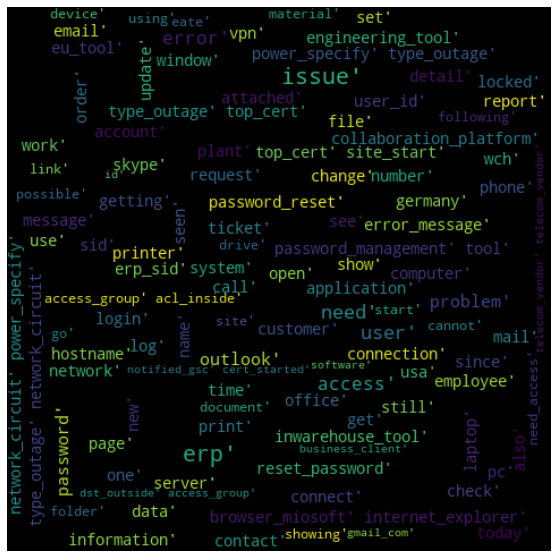

In [278]:
# Bigram word cloud
wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, ranks_only=True).generate(wordclouds_bigram)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [279]:
wordclouds_trigram=' '.join(map(str, data_words_trigrams))
wordclouds_trigram

"['login_issue_verified', 'user_detail_employee', 'name_checked_user_name', 'reset_password', 'vised_user_login', 'check_caller_confirmed_login', 'issue_resolved'] ['outlook', 'meeting', 'skype_meeting', 'appearing_outlook', 'calendar', 'somebody', 'vise_correct'] ['log_vpn', 'cannot_log', 'vpn'] ['access_hr_tool', 'page'] ['skype', 'error'] ['log', 'engineering_tool', 'skype'] ['event_itical', 'hostname', 'value_mountpoint', 'threshold_oracle', 'sid_erpdata', 'event_itical', 'hostname', 'value_mountpoint', 'threshold_oracle', 'sid_erpdata', 'psad', 'psad', 'data', 'perppsad'] ['ticket_employment', 'status', 'new_non', 'employee', 'enter_user', 'name'] ['disable', 'in', 'outlook'] ['ticket_update', 'inplant'] ['engineering_tool', 'say', 'connected', 'submit_report'] ['hr_tool', 'site_loing', 'page', 'correctly'] ['login_hr_tool', 'sgxqsuojr', 'xwbesorf', 'card'] ['user_want', 'reset_password'] ['open', 'payslip'] ['login_vpn', 'login_vpn', 'website', 'trying_open', 'new_session', 'usin

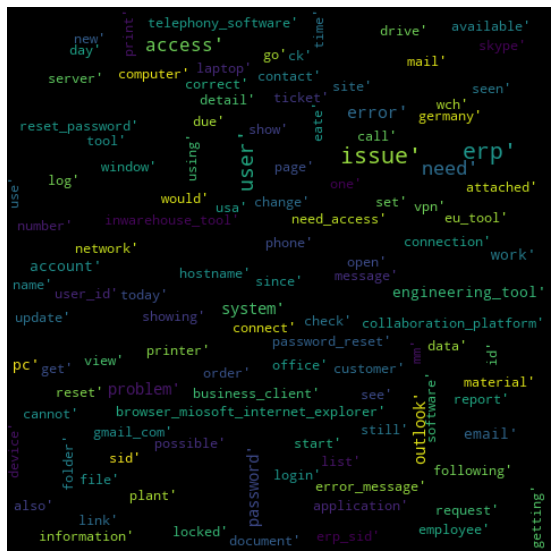

In [280]:
wordcloud_tri = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, ranks_only=True).generate(wordclouds_trigram)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_tri, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

**OBSERVATIONS:**

1. From the above word cloud visualization and text analysis, bigram is providing more meaning full words/terms. So it will be used to create the corpus.

2.  Based on Wordclouds, there is a large overlap of incidents  appearing accross mutiple groups, For example reset password, erp, jobscheduler even in other groups apart from top 5 groups

3. Analysis of a single Incident type ' Job scheduler' also reveals random spread across multiple groups

**IMPLICATIONS** - Using Bigrams has helped in reducing vocab size which addresses 'curse of Dimensionality'

#### 3. Evaluate hypothesis based on above findings and determine next steps

**HYPOTHESIS:** 

*   Each group has distinct type of incidents. There is minimal/no overlap of incidents across groups
*   Incident distribution across groups (aka classes) should not have significant imbalance

**EVALUATION:** Based on significant class imbalance and Inferences drawn from WordCloud and Incidents spread across groups, above Hypothesis is not valid. 


---


**DETERMINING NEXT STEPS:**
To proceed with classification, there are 2 scenarios emerging:
	
**Scenario 1** 
 - Ignore current group structure of 74 groups and reclassify (Topic modelling) tickets based on common incident types across all groups.
 - Observe new group structure with redued number of groups, with good distribution of tickets across groups and reduced overlap of incident type.
	
Pros
 - New group structure will have less imbalance of the incidents across groups. Lower class imbalance improves clasification accuracy.
 - Reduced overlap of incidents across groups.
 - Tangible Business Benefit: Based on resource pool, appropriate groups with lower incident resolution SLAs can be further seggregated into L1/L2 team. Those with higher SLAs for incident resolution can be directly marked to L3 teams.

Cons
 - Overrides existing group structure which may be based on current organizational factors not known to us.
 - May need skill specific resource pool to handle unique incident type across classes - This may increase resource pool size.
	
	
**Scenario 2**
 - Inspect for most common issues across each Group that are less frequent in other groups
 - Based on domain expertise, merge Groups that have similar incident types to reduce clas imbalance until we reach 'X' number of groups with similar volume distribution
 - If there are groups that continue to have lesser than 50 tickets, merge them into a single group 
  - New group structure will have redued class count (X classes), however each class will have a combination of incident types that may be uniformly distributed
	
Pros
 - May reduce class imbalance due to merging of groups
 - May reduce resource pool requirement as number of Groups will be lower than scenario 1 since multiple incident types will be clubbed in one group
	
Cons	
 - Retains existing group structure which is observed to be inaccurate with multiple incidents interspersed across groups.
 - Since each class will have a combination of incidents, Resources mapped to these classes will need to be multi skilled to handle varied incident/language type
 - Since groups are getting merged based on volume and incident type, there is a high likelihood of similar incident types being distributed across several groups leading to inefficiency
 - if there is a new incident type not trained for previously, it may be ignored as it does not fit any of the common issues/volume criteria



---
**ASSESSMENT**
 - Pros outweigh the cons in Scenario 1 and use Topic Modelling approach to reclassify  incidents into appropriate groups




### TOPIC MODELLING

**What is Topic Modelling?**

Topic modeling is a unsupervised machine learning technique that automatically analyzes text data to determine cluster words for a set of documents. It refers to the process of dividing a corpus of documents in two:

1.   A list of the topics covered by the documents in the corpus
2.   Several sets of documents from the corpus grouped by the topics they cover

Underlying assumption is that every document comprises a statistical mixture of topics, i.e. a statistical distribution of topics that can be obtained by “adding up” all of the distributions for all the topics covered. What topic modeling methods do is try to figure out which topics are present in the documents of the corpus and how strong that presence is.

**Types of Topic Modelling?**

Popular topic modeling algorithms include below among which LDA has shown great results in practice and therefore widely adopted. 

*    **K Means clustering** - k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

*    **Latent Semantic Analysis(LSA)** a.k.a Latent Semantic Indexing - LSI examines the words used in a document and looks for their relationships with other words. LSI allows a system to determine the kind of words that a document might be relevant for, even if they are not actually used on the document itself.  But having content that is full of words that have relationships with each other, you are strengthening the document for all of those words.

*   **Latent Dirichlet Allocation (LDA)** - LDA is a significant extension of LSI.  Words are grouped into topics.  They can exist in more than one topic, in fact most do.  LDA tackles ambiguity by comparing a document to two topics and determining which topic is closer to the document, across all combinations of topics which seem broadly relevant. In doing so, LDA helps to determine which documents are most relevant to which topics

*   **Hierarchical Dirichlet Process (HDP)** - HDP is an extension of LDA, designed to address the case where the number of mixture components (the number of "topics" in document-modeling terms) is not known apriori. For HDP (applied to document modeling), one also uses a Dirichlet process to capture the uncertainty in the number of topics. So a common base distribution is selected which represents the countably-infinite set of possible topics for the corpus, and then the finite distribution of topics for each document is sampled from this base distribution. 

*   **Non-negative Matrix factorization** 
Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.
Using the original matrix (A), NMF will give you two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words, A is articles by words (original), H is articles by topics and W is topics by words.


**IMPLICATION OF CHOSING A TOPIC MODELLING TECHNIQUE:**
 
 - Some of the unsupervised models like Kmeans clustering and LSA were tried, however based on research articles, other advanced techniques (LDA and NMF) were found to be more suited for Topic Modelling and extensively used

To chose between LDA, HDP and NMF:
 - Factors such as length of document (sentence), Mix of topics within the document,  usage of Word embedding, model performance will need to be evaluated during our experimentation with these models in below sections

General Steps to conduct LDA - Topic Modelling include
- Cleaning and Preprocessing
- Feature Creation using TF-IDF or BOW
- Selection of topics
- Find the best number of topics to use for the model automatically  using COHERENCE score
- Find the highest quality topics among all the topics
- Predict the topic of unseen document

In [281]:
!pip install -q pyLDAvis
#pyLDAvis is designed to help users visualize the distribution of topics from a topic model that has been fit to a corpus of text data.

In [282]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
from pprint import pprint
import pyLDAvis.gensim
warnings.filterwarnings("ignore",category=DeprecationWarning)

1. LDA Model - using BoW for feature extraction 

In [283]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus from post clean data 
texts = data_words_bigrams

# Term Document Frequency and Bag of words 
corpus = [id2word.doc2bow(text) for text in texts]


In [284]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('check_caller', 1), ('confirmed_login', 1), ('detail_employee', 1), ('issue_resolved', 1), ('login', 1), ('login_issue', 1), ('name_checked', 1), ('reset_password', 1), ('user', 1), ('user_name', 1), ('verified', 1), ('vised_user', 1)]]


**REMARK - **

We will experiment across multiple topics to evaluate coherence score and pick the best model amongst them for printing

In [285]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        #model = LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,update_every=1,chunksize=800,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [286]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=40, step=5)

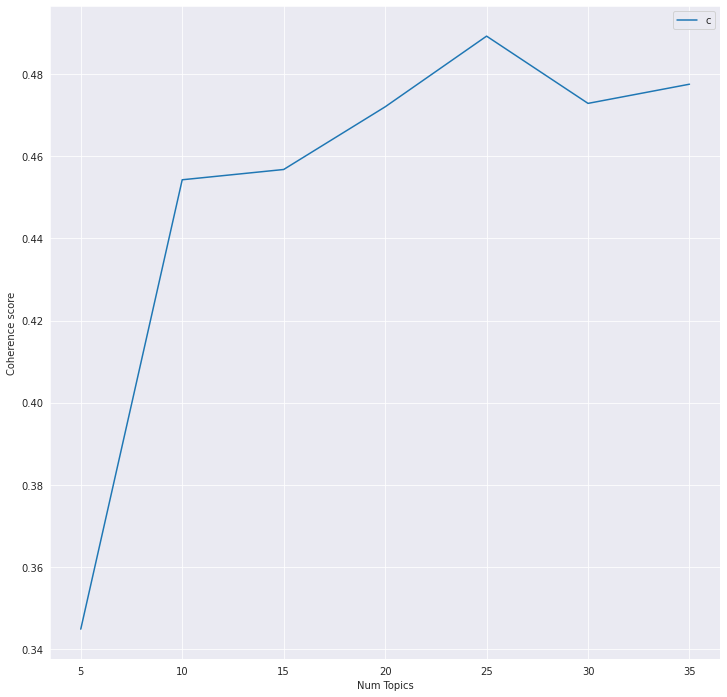

In [287]:
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [288]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3449
Num Topics = 10  has Coherence Value of 0.4543
Num Topics = 15  has Coherence Value of 0.4568
Num Topics = 20  has Coherence Value of 0.472
Num Topics = 25  has Coherence Value of 0.4892
Num Topics = 30  has Coherence Value of 0.4729
Num Topics = 35  has Coherence Value of 0.4775


**OBSERVATION: **
Highest coherence score was observed for 25 Topics which will be used as optimal model results display below

In [332]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(24,
  '0.005*"server_hostname" + 0.004*"erp_gui" + 0.003*"option" + 0.003*"app" + '
  '0.003*"eagw" + 0.003*"alwaysupservice_exe" + 0.003*"phone" + 0.003*"error" '
  '+ 0.003*"skype_meeting" + 0.003*"system"'),
 (16,
  '0.013*"job_job" + 0.008*"monitoringtool_abended" + 0.008*"terminate_action" '
  '+ 0.007*"completed" + 0.006*"supply_chain" + 0.006*"abended_job" + '
  '0.006*"job_scheduler" + 0.005*"account_unlock" + 0.005*"password_reset" + '
  '0.005*"printer"'),
 (9,
  '0.007*"access" + 0.007*"user" + 0.006*"password_reset" + 0.006*"erp" + '
  '0.006*"using_password" + 0.005*"reset_password" + 0.005*"issue" + '
  '0.005*"management_tool" + 0.004*"agent" + 0.004*"status"'),
 (23,
  '0.006*"engineering_tool" + 0.006*"defective" + 0.005*"repair" + '
  '0.004*"dell" + 0.004*"delete" + 0.004*"keep_prompting" + 0.004*"need" + '
  '0.003*"chg_approve" + 0.003*"laptop" + 0.003*"outlook"'),
 (10,
  '0.011*"password_reset" + 0.009*"erp" + 0.005*"erp_sid" + '
  '0.004*"lean_tracker" + 0.004

In [333]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.032935  0.089800       1        1  6.563832
5      0.022845 -0.062336       2        1  6.303570
14    -0.152687  0.014347       3        1  6.030544
11     0.052707 -0.058261       4        1  5.973886
7     -0.027235  0.058480       5        1  5.776692
20     0.029237  0.010064       6        1  5.203890
2     -0.023625 -0.060568       7        1  5.154869
23    -0.020493  0.013250       8        1  4.503715
3      0.028089  0.002194       9        1  4.469314
21     0.040685 -0.000529      10        1  4.341676
6      0.035936  0.030263      11        1  4.147753
0      0.004755  0.001490      12        1  3.916734
19    -0.001132 -0.025067      13        1  3.680842
16    -0.002315 -0.017761      14        1  3.337738
9     -0.021464 -0.021335      15        1  3.238655
12    -0.004283 -0.000936      16        1  3.101562
10    -0.041684 -0.022200      17        1  2.962104
17     0.003350 -0.004092      18        1  2.895658
1      0.002009  0.008716      19        1  2.772466
4      0.003594 -0.048247      20        1  2.728744
22     0.005506 -0.000988      21        1  2.626125
24     0.007926  0.036834      22        1  2.612696
13    -0.012641 -0.001082      23        1  2.581301
15     0.025286  0.032464      24        1  2.564077
8      0.012700  0.025500      25        1  2.511559, topic_info=                    Term        Freq       Total Category  logprob  loglift
1846  warehouse_toolmail   62.000000   62.000000  Default  30.0000  30.0000
106       password_reset  210.000000  210.000000  Default  29.0000  29.0000
562      business_client   87.000000   87.000000  Default  28.0000  28.0000
190              job_job   61.000000   61.000000  Default  27.0000  27.0000
46         ticket_update   51.000000   51.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
27      engineering_tool    5.773641  144.497635  Topic25  -5.9400   0.4643
122                  erp    6.039600  271.091821  Topic25  -5.8949  -0.1199
976               detail    4.556553   42.355163  Topic25  -6.1767   1.4547
463          information    4.503177   68.101420  Topic25  -6.1885   0.9681
1147            business    4.209738   23.848273  Topic25  -6.2559   1.9500

[1330 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11770      4  0.014735  abended_job
11770      5  0.029470  abended_job
11770      6  0.014735  abended_job
11770      7  0.088411  abended_job
11770      9  0.014735  abended_job
...      ...       ...          ...
14836     10  0.794257  zpress_save
3815       4  0.101075      zz_mail
3815       7  0.656988      zz_mail
3815       9  0.050538      zz_mail
3815      18  0.101075      zz_mail

[5400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 6, 15, 12, 8, 21, 3, 24, 4, 22, 7, 1, 20, 17, 10, 13, 11, 18, 2, 5, 23, 25, 14, 16, 9])

**OBSERVATION:**
 It is difficult to ascertain number of overlapped topics since above graph depicts 25 topics into 2 dimensions

 **IMPLICATION**
 - Other metrics/visualizations (eg:networkX) will need to be explored to evaluate topic distance

In [334]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=texts):
   
    sent_topics_df = pd.DataFrame()

   
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # -- dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [335]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus=corpus, texts=texts)

In [336]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.head(5)

Document_No  ...                                               Text
0            0  ...  [login_issue, verified, user, detail_employee,...
1            1  ...  [outlook, meeting, skype_meeting, appearing_ou...
2            2  ...                         [log_vpn, cannot_log, vpn]
3            3  ...                            [access, hr_tool, page]
4            4  ...                                     [skype, error]

[5 rows x 5 columns]

In [337]:
df_dominant_topic.Dominant_Topic.value_counts().describe(include='all')

count     25.000000
mean     263.360000
std       86.700096
min      143.000000
25%      201.000000
50%      250.000000
75%      293.000000
max      536.000000
Name: Dominant_Topic, dtype: float64

In [338]:
df_dominant_topic.Dominant_Topic.value_counts()

5.0     536
2.0     409
11.0    364
20.0    359
3.0     313
21.0    295
16.0    293
14.0    286
23.0    277
6.0     277
19.0    269
0.0     262
7.0     250
10.0    250
12.0    247
4.0     222
22.0    213
13.0    210
9.0     201
18.0    199
1.0     192
17.0    179
24.0    175
15.0    163
8.0     143
Name: Dominant_Topic, dtype: int64

**OBSERVATIONS:**
- There are 25 Topic groups with Coherence score 0.48
- LDA with BOW seems to have solved for class imbalance issue and also has less than half the number of Groups from initial count of 74
- Range of tickets has reduced

**IMPLICATIONS**: Factors such as Word embedding also influence quality of Topic Modelling and hence it will be prudent to try TF-IDF. Word2Vec, etc

2. LDA Model - using TF-IDF for feature extraction

In [296]:
from gensim import corpora, models

In [297]:
tfidf = models.TfidfModel(corpus)

In [298]:
corpus_tfidf = tfidf[corpus]

In [299]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.34206780033932666),
 (1, 0.3222400311399116),
 (2, 0.34206780033932666),
 (3, 0.2584552562340145),
 (4, 0.18139034011964525),
 (5, 0.27242597261069584),
 (6, 0.3607724891970962),
 (7, 0.19564540794062074),
 (8, 0.13943584270831774),
 (9, 0.28956462590546067),
 (10, 0.3382324461730324),
 (11, 0.3195277573152629)]


**REMARK - **

We will experiment across multiple topics to evaluate coherence score and pick the best model amongst them for printing

In [300]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=id2word)
        #model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, random_state = 200, alpha=0.1, id2word=id2word, passes=10, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [301]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=5, limit=40, step=5)

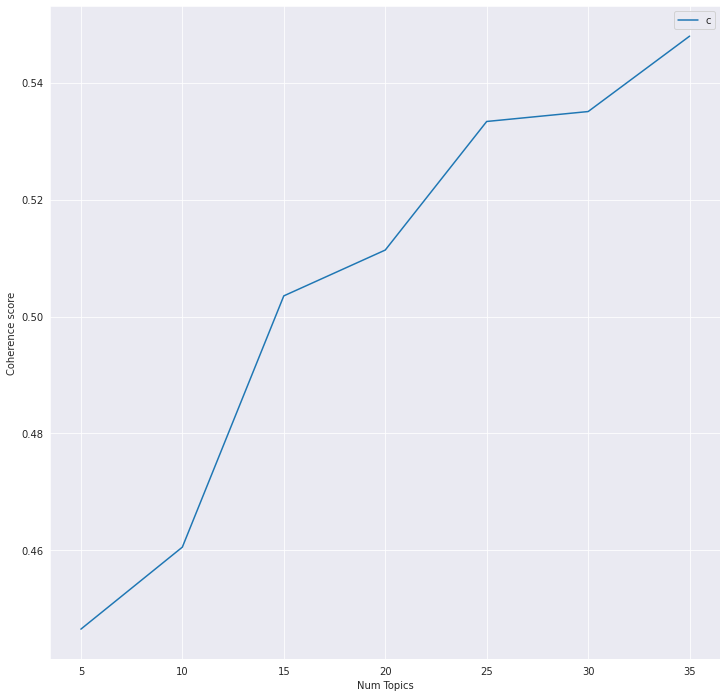

In [302]:
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [303]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 5  has Coherence Value of 0.45
Num Topics = 10  has Coherence Value of 0.46
Num Topics = 15  has Coherence Value of 0.5
Num Topics = 20  has Coherence Value of 0.51
Num Topics = 25  has Coherence Value of 0.53
Num Topics = 30  has Coherence Value of 0.54
Num Topics = 35  has Coherence Value of 0.55


**OBSERVATIONS:**

LDA with TFIDF Vectorization gives highest coherence score for 35 Topics

In [339]:
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.010*"email_cell" + 0.008*"unlock_account" + 0.006*"delete" + '
  '0.006*"phone" + 0.005*"id" + 0.005*"abended_job" + 0.005*"sto" + '
  '0.004*"job_scheduler" + 0.004*"user" + 0.004*"repair"'),
 (17,
  '0.007*"site_ckup" + 0.007*"telecom_vendor" + 0.005*"site" + 0.005*"dell" + '
  '0.004*"mio" + 0.004*"site_hard" + 0.004*"guest_account" + 0.004*"update" + '
  '0.003*"circuit_ckup" + 0.003*"et_scheduled"'),
 (28,
  '0.008*"job_running" + 0.006*"ly_needful" + 0.005*"slower" + 0.005*"de" + '
  '0.005*"job_failing" + 0.005*"amerirtcas" + 0.004*"server_hostname" + '
  '0.004*"zz_mail" + 0.004*"check" + 0.003*"outlook_pdujfybc"'),
 (32,
  '0.007*"page" + 0.007*"color" + 0.006*"request_reset" + 0.005*"vanced_find" '
  '+ 0.004*"responding" + 0.004*"problem" + 0.004*"stand" + 0.004*"lo" + '
  '0.004*"password" + 0.004*"fp"'),
 (23,
  '0.008*"group" + 0.007*"job_scheduler" + 0.006*"visio" + 0.005*"gshn" + '
  '0.005*"management" + 0.005*"form" + 0.005*"usage_wch" + '
  '0.004*"account_

In [340]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.097381 -0.049987       1        1  4.417073
25     0.117010  0.096918       2        1  4.046290
31    -0.031512 -0.017374       3        1  3.529489
30     0.028320 -0.052467       4        1  3.427163
33    -0.009537 -0.007609       5        1  3.406472
9     -0.071915  0.110289       6        1  3.391560
26     0.005598  0.001856       7        1  3.368332
20     0.014014 -0.002654       8        1  3.137389
19    -0.033854 -0.044254       9        1  3.123226
7      0.010997 -0.020315      10        1  3.111928
27    -0.009870 -0.020221      11        1  3.087705
29     0.031027  0.040306      12        1  3.082422
24     0.021458  0.035203      13        1  2.948249
28     0.020355  0.017185      14        1  2.913853
1     -0.077400  0.038405      15        1  2.850821
16    -0.008060 -0.015827      16        1  2.824562
12    -0.010531  0.021442      17        1  2.804674
6     -0.000103  0.010149      18        1  2.769742
18    -0.033715 -0.027405      19        1  2.767062
4     -0.006986 -0.022396      20        1  2.704200
8     -0.018193 -0.015544      21        1  2.643187
11    -0.000049 -0.028154      22        1  2.624043
22    -0.003751 -0.008802      23        1  2.621433
14     0.026880 -0.021594      24        1  2.619423
3      0.006649  0.005571      25        1  2.617926
2     -0.021788  0.011593      26        1  2.615121
0     -0.023025  0.030321      27        1  2.564352
34     0.003703  0.017594      28        1  2.535289
10    -0.000433 -0.011839      29        1  2.456887
21    -0.032762 -0.033176      30        1  2.409299
13     0.028077  0.013020      31        1  2.305689
32    -0.006590 -0.015583      32        1  2.199178
5     -0.004826 -0.017954      33        1  2.072360
23     0.003206 -0.014301      34        1  2.012781
15    -0.009775 -0.002397      35        1  1.990821, topic_info=                    Term       Freq      Total Category  logprob  loglift
1846  warehouse_toolmail   9.000000   9.000000  Default  30.0000  30.0000
106       password_reset  46.000000  46.000000  Default  29.0000  29.0000
562      business_client  19.000000  19.000000  Default  28.0000  28.0000
190              job_job  14.000000  14.000000  Default  27.0000  27.0000
26                 skype  25.000000  25.000000  Default  26.0000  26.0000
...                  ...        ...        ...      ...      ...      ...
576                phone   1.077406  19.112240  Topic35  -5.8151   1.0409
749                order   1.055645  17.071563  Topic35  -5.8355   1.1334
106       password_reset   1.094293  46.427414  Topic35  -5.7995   0.1688
155              contact   0.969951  14.135613  Topic35  -5.9202   1.2374
7         reset_password   0.923663  33.548370  Topic35  -5.9691   0.3242

[1795 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
12227     16  0.570320     abend_tch
11770      6  0.131835   abended_job
11770     15  0.197753   abended_job
11770     16  0.197753   abended_job
11770     18  0.065918   abended_job
...      ...       ...           ...
2579      20  0.546403       zlettel
15139     27  0.643966      zocjdutp
14836     35  0.780570   zpress_save
15627     14  0.784236  zuteillisten
3815      14  0.552532       zz_mail

[2785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 26, 32, 31, 34, 10, 27, 21, 20, 8, 28, 30, 25, 29, 2, 17, 13, 7, 19, 5, 9, 12, 23, 15, 4, 3, 1, 35, 11, 22, 14, 33, 6, 24, 16])

**OBSERVATION:**

1.  It is difficult to ascertain number of overlapped topics since above graph depicts 35 topics into 2 dimensions

2.  Hyper parameter tuning needs to be performed to find the optimal number of topics and reduce overlap between group

3. Other Word embeddings like Word2Vec will need to be evaluated to see performance difference

 **IMPLICATION**
 - Other metrics/visualizations (eg:networkX) will need to be explored to evaluate topic distance

In [341]:
def format_topics_sentences_tfidf(ldamodel=optimal_model, corpus=corpus_tfidf, texts=texts):
   
    sent_topics_df = pd.DataFrame()

   
    for i, row in enumerate(ldamodel[corpus_tfidf]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # -- dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [342]:
df_topic_sents_keywords_tfidf = format_topics_sentences_tfidf(ldamodel=optimal_model, corpus=corpus_tfidf, texts=texts)

In [343]:
df_dominant_topic_tfidf = df_topic_sents_keywords_tfidf.reset_index()
df_dominant_topic_tfidf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic_tfidf.head(5)

Document_No  ...                                               Text
0            0  ...  [login_issue, verified, user, detail_employee,...
1            1  ...  [outlook, meeting, skype_meeting, appearing_ou...
2            2  ...                         [log_vpn, cannot_log, vpn]
3            3  ...                            [access, hr_tool, page]
4            4  ...                                     [skype, error]

[5 rows x 5 columns]

Checking Topic distribution

In [344]:
df_dominant_topic_tfidf.Dominant_Topic.value_counts().describe(include='all')

count     35.000000
mean     188.114286
std       39.408697
min      114.000000
25%      167.500000
50%      182.000000
75%      211.500000
max      287.000000
Name: Dominant_Topic, dtype: float64

In [345]:
df_dominant_topic_tfidf.Dominant_Topic.value_counts()

31.0    287
33.0    262
25.0    246
30.0    240
26.0    239
17.0    232
20.0    222
1.0     221
9.0     215
27.0    208
19.0    206
12.0    197
16.0    196
7.0     192
3.0     190
28.0    188
2.0     186
29.0    182
18.0    178
24.0    178
4.0     177
6.0     175
10.0    172
34.0    172
22.0    169
8.0     168
11.0    167
14.0    162
13.0    160
21.0    147
0.0     146
32.0    145
5.0     124
15.0    121
23.0    114
Name: Dominant_Topic, dtype: int64

**OBSERVATIONS:**
- There are 35 Topic groups with Coherence score 0.55

- LDA with TFIDF vectorization seems to improved class imbalance of tickets. Range has reduced

We shall Explore with Word2Vec in more detail before Final submission 

3. Hierarchical Dirichlet Process

In [311]:
from gensim.models import CoherenceModel, HdpModel

In [312]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [313]:
hdptopics = hdpmodel.show_topics(formatted=False)

In [314]:
len(hdptopics)

20

In [315]:
topic_info = hdpmodel.print_topics(num_topics=30, num_words=10)
topic_info

[(0,
  '0.006*erp + 0.004*issue + 0.004*need + 0.003*user + 0.003*account + 0.003*access + 0.002*email + 0.002*order + 0.002*time + 0.002*system'),
 (1,
  '0.009*telecom_vendor + 0.008*site_ckup + 0.007*type_outage + 0.004*notified_gsc + 0.004*site_contact + 0.004*ditional_diagnostics + 0.004*cert_started + 0.004*dial_equipment + 0.004*notified_phone + 0.004*maintenance_power'),
 (2,
  '0.002*event_id + 0.002*source_ip + 0.002*user + 0.001*id_event + 0.001*rule_id + 0.001*pcap_hex + 0.001*file + 0.001*da + 0.001*sid + 0.001*ef'),
 (3,
  '0.005*asa_deny + 0.005*acl_inside + 0.005*dst_outside + 0.005*access_group + 0.005*tcp_inside + 0.003*inside_dst + 0.003*outside_access + 0.003*group_acl + 0.003*deny_tcp + 0.002*hostname'),
 (4,
  '0.001*explicit_notification + 0.001*id_event + 0.001*group_acl + 0.001*inside_dst + 0.001*repeat_outbound + 0.001*noris_access + 0.001*ip_dress + 0.001*domain_name + 0.001*via_gh + 0.001*event_id'),
 (5,
  '0.013*ckup_circuit + 0.008*scheduled_maintenance +

In [316]:
hdp_model_cm = CoherenceModel(model= hdpmodel, corpus= corpus, dictionary= id2word, texts= texts, coherence = "c_v")
hdp_cm = hdp_model_cm.get_coherence()
hdp_cm

0.6345203177728562

**OBSERVATIONS:**
- HDP is able to provide less number optimal topics compared to original number of groups. This model needs to be evaluated further and compare with other topic models.

 - We shall evaluate if Word Length also is a factor when chosing LDA over HDP

4. Non-Negative Matrix Factorization

In [326]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

In [327]:
new_df['CD_Lem_token_combined'].head()

0    login issue verified user detail employee name...
1    outlook meeting skype meeting appearing outloo...
2                               log vpn cannot log vpn
3                                  access hr tool page
4                                          skype error
Name: CD_Lem_token_combined, dtype: object

In [328]:
Tfidf_vectorizer = TfidfVectorizer()
X_Tfidf = Tfidf_vectorizer.fit_transform(new_df.CD_Lem_token_combined)

In [329]:
xtfidf_norm = normalize(X_Tfidf, norm='l1', axis=1)
model = NMF(n_components=5)
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [330]:
def get_nmf_topics(model, n_top_words, vectorizer, num_topics):
    
    feat_names = vectorizer.get_feature_names()    
    word_dict = {};
    for i in range(num_topics):
      words_ids = model.components_[i].argsort()[:-10 - 1:-1]
      words = [feat_names[key] for key in words_ids]
      word_dict['Topic # ' + '{:03d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [331]:
num_topics = 5
nmf_df = get_nmf_topics(model, 5, Tfidf_vectorizer, num_topics)
nmf_df

Topic # 001 Topic # 002 Topic # 003  Topic # 004     Topic # 005
0    password     outlook         erp          vpn             job
1       reset       issue     account        login       scheduler
2  management        open         sid         tool          failed
3        tool       email      locked        skype  monitoringtool
4      change    freezing      unlock  engineering         abended
5       using  responding       login        issue             sid
6         erp     dynamic        user       access        hostname
7     request    updating      window      connect          bkckup
8        need     opening        lock          log            prod
9         sid       error    unlocked      printer             bin

**Next Steps:**
  -Evaluate if Spell check contributes to improved Lemmatization of the text thereby reducing Vocab size
 - Experimenting with different word embedding models 
 - Conduct Hyperparameter tuning of different models to pick best model which has highest Coherence score and better separation between topics
  - Evaluate options for model deployment in production


